In [1]:
import pandas as pd
import urllib
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator


## Downloading dataset

In [2]:
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/volkamerlab/teachopencadd/master/teachopencadd/talktorials/T002_compound_adme/data/EGFR_compounds_lipinski.csv",
    "dataset.csv",
)

('dataset.csv', <http.client.HTTPMessage at 0x175ad8c5820>)

In [3]:
df = pd.read_csv('dataset.csv').drop(columns=["Unnamed: 0"])
df

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL63786,3.000000e-03,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.28910,True
1,CHEMBL35820,6.000000e-03,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.93330,True
2,CHEMBL53711,6.000000e-03,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.59690,True
3,CHEMBL66031,8.000000e-03,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.01220,True
4,CHEMBL53753,8.000000e-03,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.57260,True
...,...,...,...,...,...,...,...,...,...,...
4630,CHEMBL120564,2.600000e+06,nM,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027,214.074228,4,1,2.13978,True
4631,CHEMBL66879,3.000000e+06,nM,O=C(O)/C=C/c1ccc(O)cc1,2.522879,164.047344,2,2,1.49000,True
4632,CHEMBL261238,5.000000e+06,nM,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,404.095250,6,1,5.20048,True
4633,CHEMBL76587,6.500000e+06,nM,N#CC(C#N)Cc1ccc(O)cc1,2.187087,172.063663,3,1,1.59806,True


In [4]:
df = df[["molecule_chembl_id", "smiles", "pIC50"]]
# Add column for activity
df["active"] = np.zeros(len(df))

# Mark every molecule as active with an pIC50 of >= 8.0, 0 otherwise
pIC50_cut_off = 8.0
df.loc[df[df.pIC50 >= pIC50_cut_off].index, "active"] = 1.0
df

C:\Users\mehra\AppData\Local\Temp\ipykernel_10736\1884176641.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["active"] = np.zeros(len(df))


,molecule_chembl_id,smiles,pIC50,active
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,1.0
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,1.0
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,1.0
3,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,1.0
4,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,1.0
...,...,...,...,...
4630,CHEMBL120564,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027,0.0
4631,CHEMBL66879,O=C(O)/C=C/c1ccc(O)cc1,2.522879,0.0
4632,CHEMBL261238,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,0.0
4633,CHEMBL76587,N#CC(C#N)Cc1ccc(O)cc1,2.187087,0.0


## Molecule encoding

In [5]:
import selfies as sf

def smiles_to_selfies(smiles):
    """
    Encode a molecule from a SMILES string into a SELFIES.
    
    Parameters
    ----------
        smiles : str
        The SMILES string defining the molecule.

    Returns
    -------
    string
        SELFIES representation
    """

    return sf.encoder(smiles)


def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    if method == "morgan3":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

from rdkit.Chem import AllChem, Descriptors
def smiles_to_other_desc(smiles):
    mol = Chem.MolFromSmiles(smiles)
    desc = [Descriptors.MolWt(mol), Descriptors.NumRotatableBonds(mol), Descriptors.TPSA(mol)]
    return desc

def smiles_to_mordred(smiles):
    mol = Chem.MolFromSmiles(smiles)
    # Create Calculator for mordred features
    mordred_calc = Calculator(descriptors, ignore_3D=True)
    return mordred_calc(mol)

In [6]:
from molfeat.trans import MoleculeTransformer
transformer = MoleculeTransformer(featurizer='mordred', dtype=float)

# This takes forever to run, so just loaking the pickled file
# df['mordred'] = df["smiles"].apply(transformer)
df['mordred'] = pd.read_pickle('mordred_descriptors.pkl')
mordred_array = np.array([list(array[0]) for array in df['mordred']])

C:\Users\mehra\AppData\Local\Temp\ipykernel_10736\2197280482.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mordred'] = pd.read_pickle('mordred_descriptors.pkl')


In [78]:
df['mordred'].iloc[0]

array([[         nan,          nan,   0.        , ..., 142.        ,
          5.27777778,   4.75      ]])

In [8]:
# Identify columns with NaN values
nan_columns = np.isnan(mordred_array).any(axis=0)
# Extract columns without NaN values
mordred_array_without_nan = mordred_array[:, ~nan_columns]

# dropping features with 0 std
mask = mordred_array_without_nan.std(axis=0) != 0
mordred_array_without_nan = mordred_array_without_nan[:, mask]

In [13]:
mordred_array_without_nan.shape

(4635, 657)

In [85]:
cols_idxs

array([ 12, 203, 298, 312, 316, 340, 354, 358, 387, 388, 444, 455, 503,
       514, 523, 527, 556, 565, 572, 578], dtype=int64)

<Axes: >

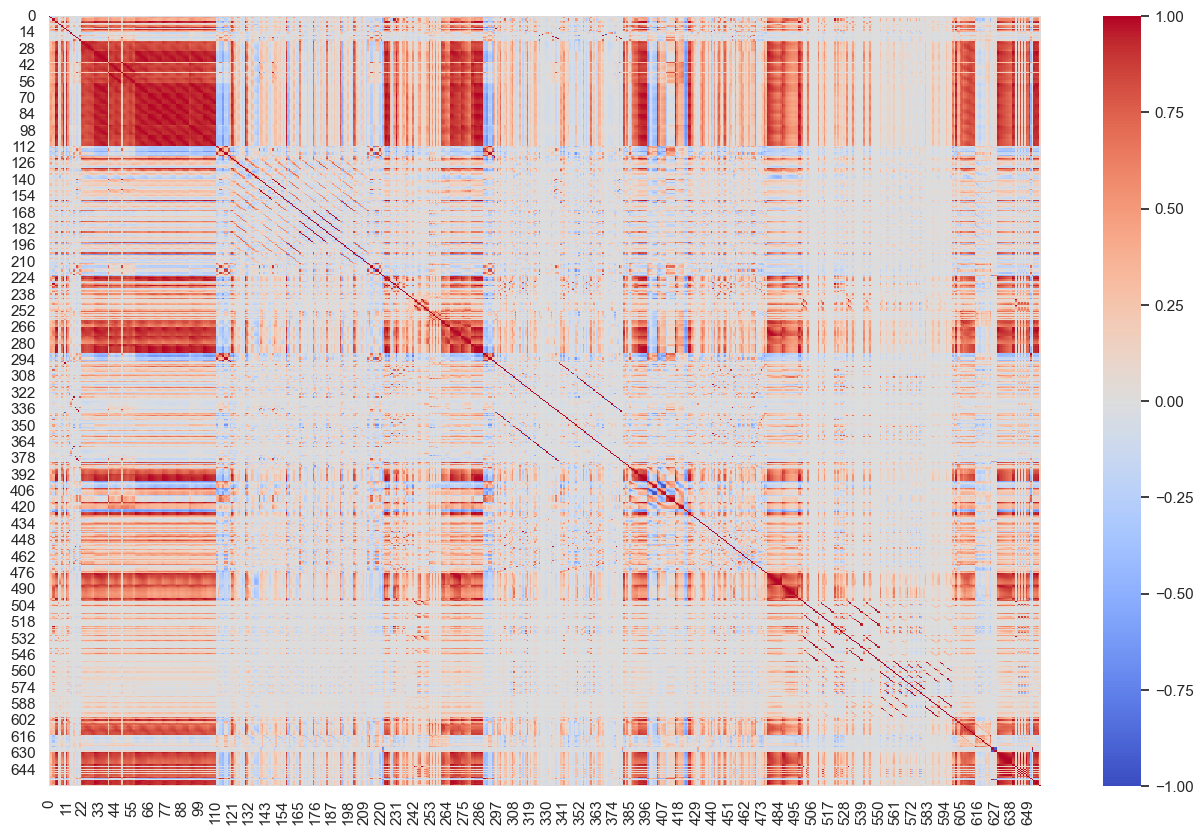

In [80]:
import seaborn as sns

correlation_matrix = np.corrcoef(mordred_array_without_nan, y, rowvar=False)
sns.set(rc = {'figure.figsize':(16,10)})
sns.heatmap(correlation_matrix, annot = False, fmt='.2g',cmap= 'coolwarm', vmin=-1, vmax=1)

In [233]:
# Set the correlation threshold
threshold = 0.84

# Find the indices of features with at least one correlation lower than the threshold
uncorrelated_feature_indices = np.where(np.all(np.abs(correlation_matrix) < threshold, axis=0))[0]
len(uncorrelated_feature_indices)

0

In [15]:
fp = 'maccs'
df["finger print"] = df["smiles"].apply(smiles_to_fp, method= fp)
df['selfies'] = df["smiles"].apply(smiles_to_selfies)
df['other features'] = df["smiles"].apply(smiles_to_selfies)

df

C:\Users\mehra\AppData\Local\Temp\ipykernel_10736\3384529567.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["finger print"] = df["smiles"].apply(smiles_to_fp, method= fp)
C:\Users\mehra\AppData\Local\Temp\ipykernel_10736\3384529567.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['selfies'] = df["smiles"].apply(smiles_to_selfies)
C:\Users\mehra\AppData\Local\Temp\ipykernel_10736\3384529567.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

,molecule_chembl_id,smiles,pIC50,active,mordred,finger print,selfies,other desc
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,1.0,"[[nan, nan, 0.0, 0.0, 29.423733093258964, 2.45...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Br][C][=C][C][=C][C][Branch2][Ring1][=Branch1...,"[350.21900000000005, 2, 37.81]"
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,1.0,"[[nan, nan, 0.0, 0.0, 30.892598877733853, 2.44...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][C][O][C][=C][C][=N][C][=N][C][Branch1][=N]...,"[388.26500000000016, 6, 56.27000000000001]"
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,1.0,"[[nan, nan, 0.0, 0.0, 26.963354037820416, 2.42...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][N][Branch1][C][C][C][=C][C][=C][Branch1][=...,"[344.216, 3, 53.94]"
3,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,1.0,"[[nan, nan, 0.0, 0.0, 27.96969874559524, 2.464...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Br][C][=C][C][=C][C][Branch2][Ring1][Branch1]...,"[340.184, 2, 66.49000000000001]"
4,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,1.0,"[[nan, nan, 0.0, 0.0, 26.20363544304582, 2.411...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][N][C][=C][C][=C][Branch1][=N][N][C][=C][C]...,"[330.189, 3, 62.730000000000004]"
...,...,...,...,...,...,...,...,...
4630,CHEMBL120564,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027,0.0,"[[nan, nan, 0.0, 0.0, 19.82363777416666, 2.351...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][O][C][=C][C][Branch1][=Branch2][C][=C][Bra...,"[214.224, 2, 77.03999999999999]"
4631,CHEMBL66879,O=C(O)/C=C/c1ccc(O)cc1,2.522879,0.0,"[[nan, nan, 1.0, 0.0, 14.455241848321613, 2.21...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[O][=C][Branch1][C][O][/C][=C][/C][=C][C][=C][...,"[164.16, 2, 57.53]"
4632,CHEMBL261238,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,0.0,"[[nan, nan, 0.0, 0.0, 38.38441318822173, 2.466...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][N][Branch1][=Branch2][C][=C][C][=C][N][=C]...,"[404.8360000000001, 4, 77.73]"
4633,CHEMBL76587,N#CC(C#N)Cc1ccc(O)cc1,2.187087,0.0,"[[nan, nan, 0.0, 0.0, 16.199542565312125, 2.23...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[N][#C][C][Branch1][Ring1][C][#N][C][C][=C][C]...,"[172.187, 2, 67.81]"


In [16]:
alphabet = sf.get_alphabet_from_selfies(df['selfies'].to_list())
alphabet.add('[nop]') # This is a special padding symbol
alphabet.add('.')
alphabet = list(sorted(alphabet))
voc = {s: i for i, s in enumerate(alphabet)}
pad_to_len = max(sf.len_selfies(s) for s in df["selfies"])
voc['[nop]'] = 0 
voc['.'] = 58

In [17]:
voc

{'.': 58,
 '[#Branch1]': 1,
 '[#Branch2]': 2,
 '[#C]': 3,
 '[#N]': 4,
 '[/C@@H1]': 5,
 '[/C@H1]': 6,
 '[/C]': 7,
 '[/Cl]': 8,
 '[/F]': 9,
 '[/N+1]': 10,
 '[/N]': 11,
 '[/O]': 12,
 '[=Branch1]': 13,
 '[=Branch2]': 14,
 '[=C]': 15,
 '[=N+1]': 16,
 '[=N-1]': 17,
 '[=N]': 18,
 '[=O+1]': 19,
 '[=O]': 20,
 '[=P]': 21,
 '[=Ring1]': 22,
 '[=Ring2]': 23,
 '[=S]': 24,
 '[B]': 25,
 '[Br-1]': 26,
 '[Br]': 27,
 '[Branch1]': 28,
 '[Branch2]': 29,
 '[C@@H1]': 30,
 '[C@@]': 31,
 '[C@H1]': 32,
 '[C@]': 33,
 '[C]': 34,
 '[Cl-1]': 35,
 '[Cl]': 36,
 '[F]': 37,
 '[I]': 38,
 '[N+1]': 39,
 '[NH1]': 40,
 '[N]': 41,
 '[O-1]': 42,
 '[OH0]': 43,
 '[O]': 44,
 '[P]': 45,
 '[Ring1]': 46,
 '[Ring2]': 47,
 '[S+1]': 48,
 '[S]': 49,
 '[Se]': 50,
 '[Si]': 51,
 '[Zn+2]': 52,
 '[\\C]': 53,
 '[\\F]': 54,
 '[\\N]': 55,
 '[\\O]': 56,
 '[\\S]': 57,
 '[nop]': 0}

In [18]:
def selfies_to_encoding(selfies):
  # try:
    label = sf.selfies_to_encoding(
      selfies=selfies,
      vocab_stoi=voc,
      pad_to_len=pad_to_len,
      enc_type="label"
    )
  # except:
  #   # print(selfies)
  #   return None
    return label

df['encoding'] = df["selfies"].apply(selfies_to_encoding)
df

C:\Users\mehra\AppData\Local\Temp\ipykernel_10736\1326549249.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['encoding'] = df["selfies"].apply(selfies_to_encoding)


,molecule_chembl_id,smiles,pIC50,active,mordred,finger print,selfies,other desc,encoding
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,1.0,"[[nan, nan, 0.0, 0.0, 29.423733093258964, 2.45...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Br][C][=C][C][=C][C][Branch2][Ring1][=Branch1...,"[350.21900000000005, 2, 37.81]","[27, 34, 15, 34, 15, 34, 29, 46, 13, 41, 34, 1..."
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,1.0,"[[nan, nan, 0.0, 0.0, 30.892598877733853, 2.44...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][C][O][C][=C][C][=N][C][=N][C][Branch1][=N]...,"[388.26500000000016, 6, 56.27000000000001]","[34, 34, 44, 34, 15, 34, 18, 34, 18, 34, 28, 1..."
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,1.0,"[[nan, nan, 0.0, 0.0, 26.963354037820416, 2.42...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][N][Branch1][C][C][C][=C][C][=C][Branch1][=...,"[344.216, 3, 53.94]","[34, 41, 28, 34, 34, 34, 15, 34, 15, 28, 18, 4..."
3,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,1.0,"[[nan, nan, 0.0, 0.0, 27.96969874559524, 2.464...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Br][C][=C][C][=C][C][Branch2][Ring1][Branch1]...,"[340.184, 2, 66.49000000000001]","[27, 34, 15, 34, 15, 34, 29, 46, 28, 41, 34, 1..."
4,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,1.0,"[[nan, nan, 0.0, 0.0, 26.20363544304582, 2.411...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][N][C][=C][C][=C][Branch1][=N][N][C][=C][C]...,"[330.189, 3, 62.730000000000004]","[34, 41, 34, 15, 34, 15, 28, 18, 41, 34, 15, 3..."
...,...,...,...,...,...,...,...,...,...
4630,CHEMBL120564,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027,0.0,"[[nan, nan, 0.0, 0.0, 19.82363777416666, 2.351...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][O][C][=C][C][Branch1][=Branch2][C][=C][Bra...,"[214.224, 2, 77.03999999999999]","[34, 44, 34, 15, 34, 28, 14, 34, 15, 28, 46, 3..."
4631,CHEMBL66879,O=C(O)/C=C/c1ccc(O)cc1,2.522879,0.0,"[[nan, nan, 1.0, 0.0, 14.455241848321613, 2.21...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[O][=C][Branch1][C][O][/C][=C][/C][=C][C][=C][...,"[164.16, 2, 57.53]","[44, 15, 28, 34, 44, 7, 15, 7, 15, 34, 15, 28,..."
4632,CHEMBL261238,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,0.0,"[[nan, nan, 0.0, 0.0, 38.38441318822173, 2.466...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[C][N][Branch1][=Branch2][C][=C][C][=C][N][=C]...,"[404.8360000000001, 4, 77.73]","[34, 41, 28, 14, 34, 15, 34, 15, 41, 15, 46, 1..."
4633,CHEMBL76587,N#CC(C#N)Cc1ccc(O)cc1,2.187087,0.0,"[[nan, nan, 0.0, 0.0, 16.199542565312125, 2.23...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[N][#C][C][Branch1][Ring1][C][#N][C][C][=C][C]...,"[172.187, 2, 67.81]","[41, 3, 34, 28, 46, 34, 4, 34, 34, 15, 34, 15,..."


In [19]:
df['encoding'].iloc[0]

[27,
 34,
 15,
 34,
 15,
 34,
 29,
 46,
 13,
 41,
 34,
 18,
 34,
 18,
 34,
 15,
 34,
 15,
 34,
 15,
 34,
 15,
 46,
 13,
 34,
 15,
 46,
 15,
 46,
 2,
 15,
 47,
 46,
 28,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

## Baseline model

In [11]:
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_curves_for_models(models, test_x, test_y, save_png=False, finger_print=None):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"), alpha=0.8)

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC - FP: {finger_print}")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"roc_auc_{finger_print}", dpi=300, bbox_inches="tight", transparent=True)
    return fig

def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = map(np.array, splits)

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

### Train-test split

In [101]:
from sklearn.model_selection import KFold, train_test_split

SEED = 22

X = np.vstack(df['finger print'])
y = np.vstack(df['active'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Second split: Split into half for validation and test sets (i.e., 10% each of original data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=SEED)

splits = [X_train, X_test, y_val, y_val]

print(f"Training size: {len(X_train)}")
print(f"Val size: {len(y_val)}")
print(f"Test size: {len(y_test)}")

Training size: 3708
Val size: 463
Test size: 464


(array([2996.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         712.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

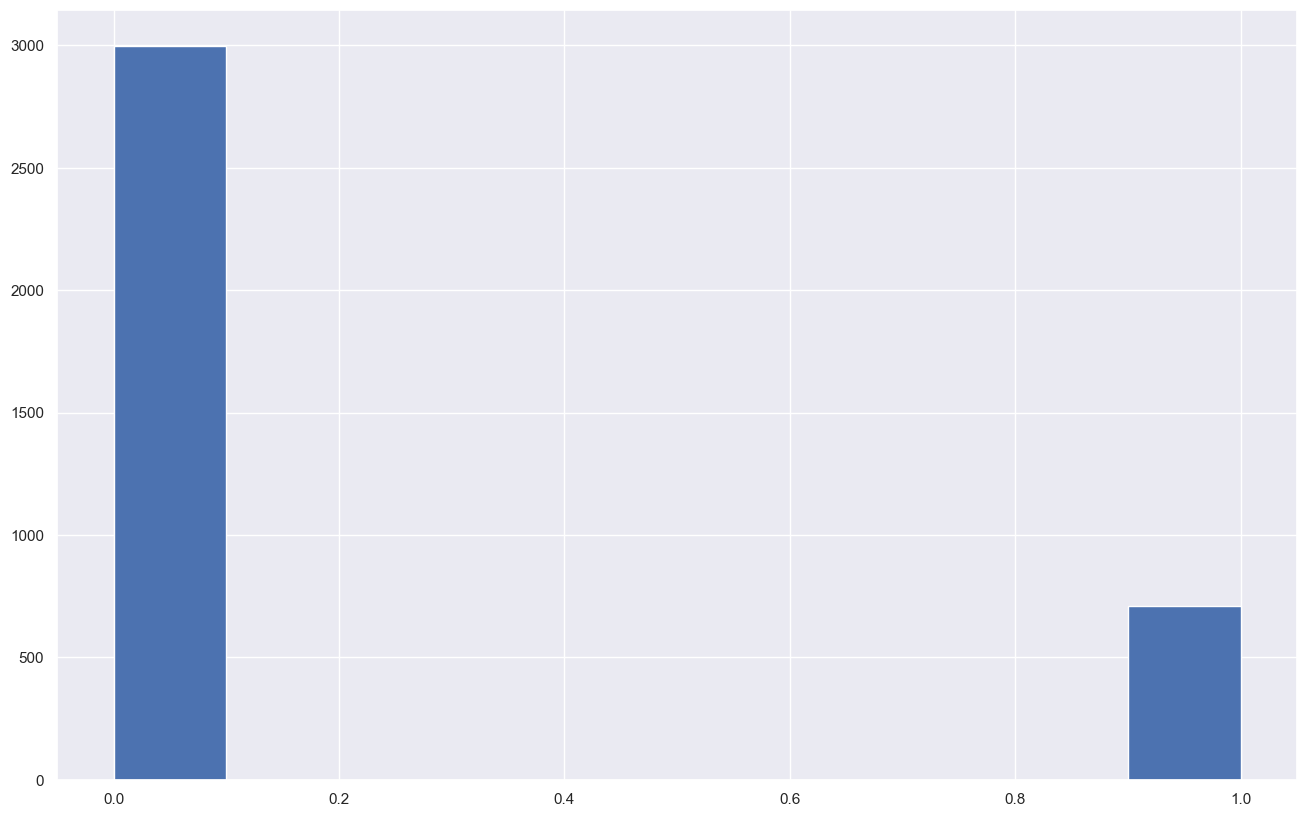

In [100]:
plt.hist(y_train)

In [150]:
# from imblearn.over_sampling import SMOTE

# oversample = SMOTE()
# X_train, y_train = oversample.fit_resample(X_train,y_train)

In [160]:
# plt.hist(y_train)

### Random forest classifier

In [161]:
from sklearn.ensemble import RandomForestClassifier
# Set model parameter for random forest
param = {
    "n_estimators": 150,  # number of trees to grows
    "criterion": "entropy",  # loss function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [162]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

C:\Users\mehra\anaconda3\envs\valance\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Sensitivity: 0.51
Specificity: 0.94
AUC: 0.87


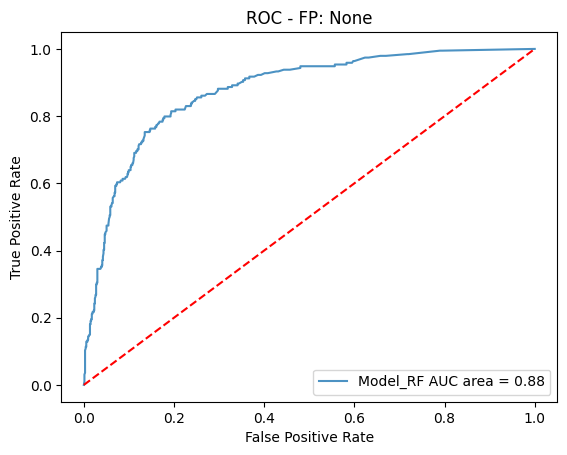

In [55]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
# Plot roc curve
plot_roc_curves_for_models(models, X_test, y_test);

### Support vector classifier

In [154]:
from sklearn import svm, metrics, clone
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

C:\Users\mehra\anaconda3\envs\valance\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Sensitivity: 0.35
Specificity: 0.98
AUC: 0.85


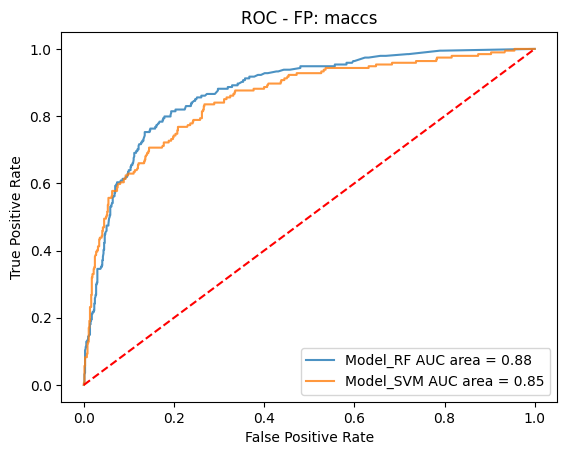

In [57]:
# Append SVM model
new_model = {"label": "Model_SVM", "model": model_SVM}

if not any(existing_model['label'] == new_model['label'] for existing_model in models):
    models.append(new_model)
# Plot roc curve
plot_roc_curves_for_models(models, X_test, y_test, save_png=True, finger_print=fp);

### Deep Neural Network

In [12]:
import tensorflow as tf
from dataclasses import dataclass

In [13]:
from imblearn.over_sampling import SMOTE

In [205]:
@dataclass
class Config:
    batch_size: int
    hidden_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(
                batch_size=32, 
                hidden_dim=16,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.3
               )

def build_model(L):
    inputs = tf.keras.Input(shape=(L,))
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='tanh', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(inputs)
    # x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 8, 
        activation='tanh', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    # x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    yhat = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=yhat, name='DNN')
    return model

In [206]:
tf.keras.backend.clear_session()
L = np.array(X_train).shape[1]
model_DNN = build_model(L)
opt = tf.optimizers.Adam(config.lr)
model_DNN.compile(
      opt,
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
      metrics=[tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.BinaryAccuracy(threshold=0.5)])

model_DNN.summary()

Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 167)]             0         
                                                                 
 dense (Dense)               (None, 16)                2688      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
 dropout_1 (Dropout)         (None, 2)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 2725 (10.64 KB)
Trainable params: 2725 (10.64 KB)

In [211]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_auc',  # Metric to be monitored
                             factor=0.95,          # Factor by which the learning rate will be reduced
                             patience=20,         # No. of epochs with no improvement after which learning rate will be reduced
                             min_lr=0.00001,      # Lower bound on the learning rate
                             verbose=1) 

result = model_DNN.fit(
    np.array(X_train), np.array(y_train), 
    validation_data=(np.array(X_test), np.array(y_test)), 
    callbacks=[reduce_lr,
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=30)],
    epochs=200, batch_size=config.batch_size)

Epoch 1/200
116/116 [==============================] - 1s 7ms/step - loss: 0.3536 - auc: 0.8550 - binary_accuracy: 0.8331 - val_loss: 0.3729 - val_auc: 0.8493 - val_binary_accuracy: 0.8350 - lr: 6.3025e-04
Epoch 2/200
116/116 [==============================] - 1s 5ms/step - loss: 0.3615 - auc: 0.8463 - binary_accuracy: 0.8323 - val_loss: 0.3746 - val_auc: 0.8512 - val_binary_accuracy: 0.8317 - lr: 6.3025e-04
Epoch 3/200
116/116 [==============================] - 1s 5ms/step - loss: 0.3563 - auc: 0.8513 - binary_accuracy: 0.8417 - val_loss: 0.3839 - val_auc: 0.8508 - val_binary_accuracy: 0.8177 - lr: 6.3025e-04
Epoch 4/200
116/116 [==============================] - 1s 5ms/step - loss: 0.3575 - auc: 0.8527 - binary_accuracy: 0.8336 - val_loss: 0.3709 - val_auc: 0.8494 - val_binary_accuracy: 0.8350 - lr: 6.3025e-04
Epoch 5/200
116/116 [==============================] - 1s 5ms/step - loss: 0.3495 - auc: 0.8602 - binary_accuracy: 0.8371 - val_loss: 0.3725 - val_auc: 0.8491 - val_binary_accu

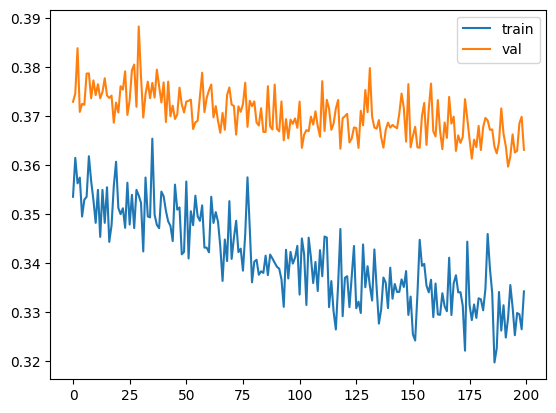

In [212]:
plt.plot(result.history['loss'], label='train')
plt.plot(result.history['val_loss'], label='val')
plt.legend()

In [214]:
test_result = model_DNN.evaluate(np.array(X_test), np.array(y_test))

29/29 [==============================] - 0s 4ms/step - loss: 0.3631 - auc: 0.8607 - binary_accuracy: 0.8490


### Recurrent Neural Network

In [33]:
from sklearn.model_selection import KFold, train_test_split
import numpy as np
import tensorflow as tf
from dataclasses import dataclass

SEED = 22

X_e = np.vstack(df['encoding'])
X_= np.vstack(df['finger print'])
# X_m = np.vstack(df['other desc'])
X_m = mordred_array_without_nan
X = np.concatenate([X_e, X_,X_m],axis=1)


y = np.vstack(df['active'])

(
    X_train,
    X_test,
    y_train,
    y_test,
) = train_test_split(X, y, test_size=0.2, random_state=SEED)

# oversample = SMOTE()
# X_train, y_train = oversample.fit_resample(X_train,y_train)

splits = [X_train, X_test, y_train, y_test]

print("Training size:", len(X_train))
print("Test size:", len(y_test))

Training size: 3708
Test size: 927


In [34]:
X_e.shape

(4635, 87)

In [35]:
X_m.shape

(4635, 657)

In [36]:
X_.shape

(4635, 2048)

In [37]:
X_train.shape

(3708, 2792)

### Scale

In [38]:
X_train[:, -1].std()

1.3876698779376302

In [86]:
from sklearn.preprocessing import StandardScaler


j = X_train.shape[1]- len(df['encoding'].iloc[0])
print(j)
 # k = len(df['other desc'].iloc[0])
k = mordred_array_without_nan.shape[1]
print(k)

selected_indices = [ 12, 203, 298, 312, 316, 340, 354, 358, 387, 388, 444, 455, 503,
       514, 523, 527, 556, 565, 572, 578]

X_train_input_f = X_train[:, -j:-k]
X_test_input_f = X_test[:, -j:-k]
X_train_input_m = X_train[:, -k:][:, selected_indices]
X_test_input_m = X_test[:, -k:][:, selected_indices]

scaler = StandardScaler().fit(X_train_input_m)
X_train_input_m = scaler.transform(X_train_input_m) 
X_test_input_m = scaler.transform(X_test_input_m) 


X_train_input = X_train[:, :-j]
X_test_input = X_test[:, :-j]
# X_test_standardized = scaler.transform(X_test)

2705
657


In [88]:
X_train_input_m.shape

(3708, 20)

(array([2996.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         712.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

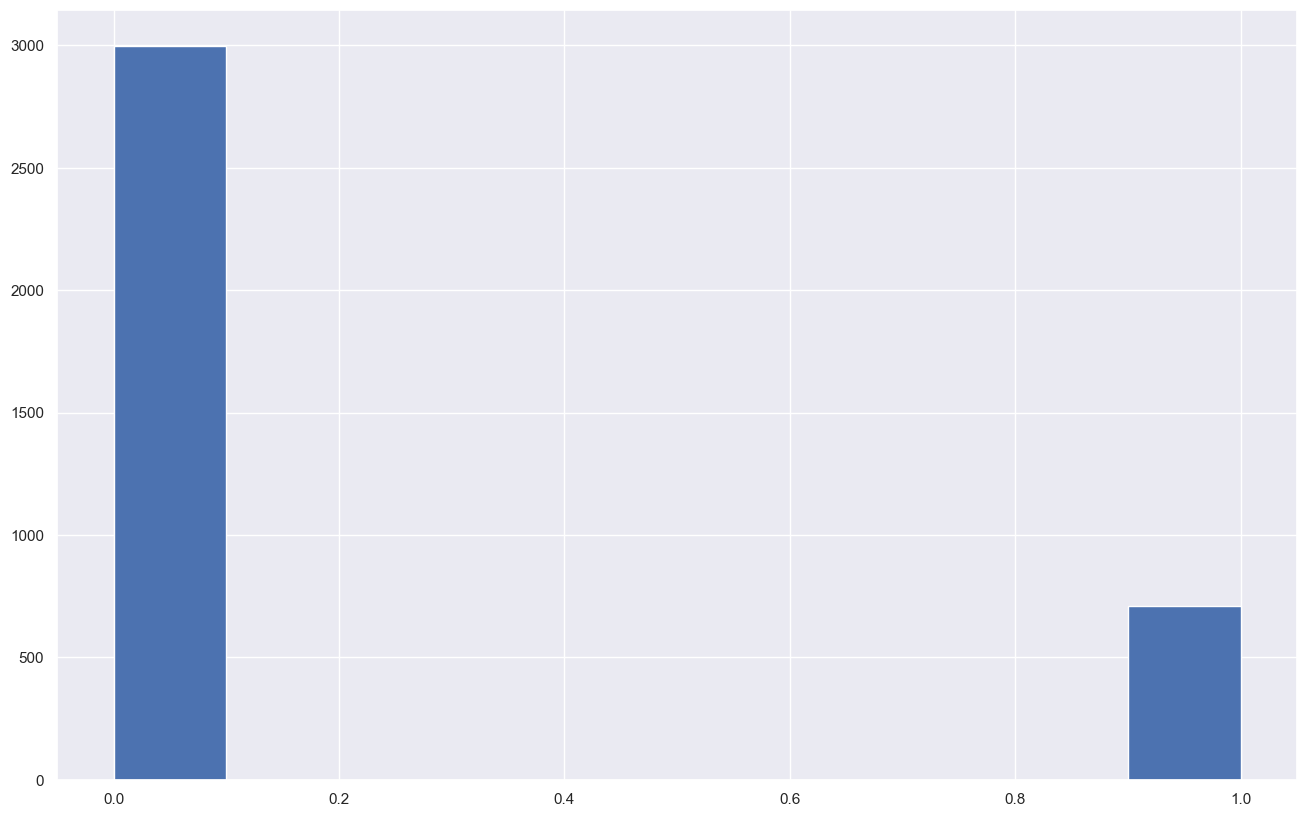

In [87]:
from matplotlib import pyplot as plt
plt.hist(y_train)

In [41]:
# @dataclass
# class LSTM_Config:
#     vocab_size: int = len(voc)
#     batch_size: int = 64
#     buffer_size: int = 10000
#     rnn_units: int = 32
#     hidden_dim: int = 32
#     embedding_dim: int = 32
#     reg_strength: float = 0
#     lr: float = 1e-3
#     drop_rate: float = 0.3
#     epochs: int = 150
#     nmodels: int = 1
#     adv_epsilon: float = 1e-3

In [93]:
@dataclass
class LSTM_Config:
    vocab_size: int = len(voc)
    batch_size: int = 32
    buffer_size: int = 10000
    rnn_units: int = 8
    hidden_dim: int = 32
    embedding_dim: int = 16
    reg_strength: float = 0.001
    lr: float = 1e-4
    drop_rate: float = 0.25
    epochs: int = 150
    nmodels: int = 1
    adv_epsilon: float = 1e-3

lstm_config = LSTM_Config()

count_zeros = np.sum(y_train == 0)
count_non_zeros = np.sum(y_train == 1)
output_bias = tf.keras.initializers.Constant(np.log([count_non_zeros/count_zeros])) 

print(f"Inital bias = {output_bias}")


def build_LSTM_model(L=None, output_bias = output_bias):
    input = tf.keras.Input(shape=(L,))
    input_f = tf.keras.Input(shape=(2048,))
    input_m = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=lstm_config.vocab_size,
                                  output_dim=lstm_config.embedding_dim,
                                  mask_zero=True)(input)
    # e = tf.keras.layers.Dropout(lstm_config.drop_rate)(e)
    # RNN layer
    # x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_config.rnn_units, activation=None))(e)
    # x = tf.keras.layers.LSTM(lstm_config.rnn_units, activation=None)(e)
    # x = tf.keras.layers.GRU(lstm_config.rnn_units, activation=None)(e)
    # x = tf.keras.layers.LayerNormalization()(x)
    
    # print(x.shape)
    # print(input_f.shape)
    x = tf.keras.layers.Concatenate()([x, input_f, input_m])
    
    x = tf.keras.layers.Concatenate(axis=1)([x, input_f])
    
    # print(x.shape)
    x = tf.keras.layers.Dropout(lstm_config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        lstm_config.hidden_dim,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(lstm_config.reg_strength))(x)
    # x = tf.keras.layers.Concatenate(axis=1)([x, input_m])
    # x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(lstm_config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        lstm_config.hidden_dim // 2,
        activation='tanh',
        kernel_regularizer=tf.keras.regularizers.l2(lstm_config.reg_strength))(x)
    # x = tf.keras.layers.LayerNormalization()(x)
    # predicting prob, so no activation
    output = tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=None)(x)

    model = tf.keras.Model(inputs=[input, input_f, input_m], outputs=output, name='LSTM')
    return model #, partial_in, partial_out

Inital bias = <keras.src.initializers.initializers.Constant object at 0x00000175F4614CA0>


In [94]:
# total_samples = len(y_train)
# count_zeros = np.sum(y_train == 0)
# count_non_zeros = np.sum(y_train == 1)
# class_weights = {0: total_samples / count_zeros, 1: total_samples / count_non_zeros}  # Adjust the weights as needed
# regularization_strength = 0  # Adjust the regularization strength as needed

# def weighted_loss(y_true, y_pred):
#     # Compute the binary cross-entropy loss
#     loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)

#     # Apply class weights
#     weights = tf.reduce_sum(tf.constant(list(class_weights.values())) * y_true, axis=1)
#     weighted_loss = tf.reduce_mean(loss * weights)

#     # Add regularization term (L2 regularization in this example)
#     regularizer = tf.keras.regularizers.l2(regularization_strength)
#     reg_term = regularizer(model_LSTM.trainable_variables)
    
#     return weighted_loss + reg_term

# class_weights

In [95]:
tf.keras.backend.clear_session()
L = X_train_input.shape[1]
model_LSTM = build_LSTM_model(L)
opt = tf.optimizers.Adam(lstm_config.lr)
model_LSTM.compile(
      opt,
      loss= tf.keras.losses.BinaryCrossentropy(from_logits=False),
      metrics=[tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.BinaryAccuracy(threshold=0.5)])

model_LSTM.summary()

Model: "LSTM"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 87)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 87, 16)               944       ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 16)                   1600      ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                         

In [96]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_auc',  # Metric to be monitored
                             factor=0.9,          # Factor by which the learning rate will be reduced
                             patience=8,         # No. of epochs with no improvement after which learning rate will be reduced
                             min_lr=0.00001,      # Lower bound on the learning rate
                             verbose=1) 

result = model_LSTM.fit(
    [X_train_input, X_train_input_f, X_train_input_m], y_train, 
    validation_data=([X_test_input, X_test_input_f, X_test_input_m], y_test), 
    callbacks=[reduce_lr,
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=10)],
    epochs=200, batch_size=lstm_config.batch_size)

Epoch 1/200
116/116 [==============================] - 27s 157ms/step - loss: 0.6948 - auc: 0.4756 - binary_accuracy: 0.6607 - val_loss: 0.5775 - val_auc: 0.6445 - val_binary_accuracy: 0.7907 - lr: 1.0000e-04
Epoch 2/200
116/116 [==============================] - 16s 142ms/step - loss: 0.5362 - auc: 0.7081 - binary_accuracy: 0.8099 - val_loss: 0.5128 - val_auc: 0.8185 - val_binary_accuracy: 0.7983 - lr: 1.0000e-04
Epoch 3/200
116/116 [==============================] - 17s 143ms/step - loss: 0.4864 - auc: 0.8132 - binary_accuracy: 0.8225 - val_loss: 0.4791 - val_auc: 0.8406 - val_binary_accuracy: 0.8101 - lr: 1.0000e-04
Epoch 4/200
116/116 [==============================] - 16s 138ms/step - loss: 0.4540 - auc: 0.8419 - binary_accuracy: 0.8339 - val_loss: 0.4585 - val_auc: 0.8551 - val_binary_accuracy: 0.8231 - lr: 1.0000e-04
Epoch 5/200
116/116 [==============================] - 16s 141ms/step - loss: 0.4278 - auc: 0.8652 - binary_accuracy: 0.8484 - val_loss: 0.4363 - val_auc: 0.8626 - 

In [102]:
model_LSTM.evaluate([X_test_input, X_test_input_f, X_test_input_m], y_test)

ValueError: Data cardinality is ambiguous:
  x sizes: 927, 927, 927
  y sizes: 464
Make sure all arrays contain the same number of samples.

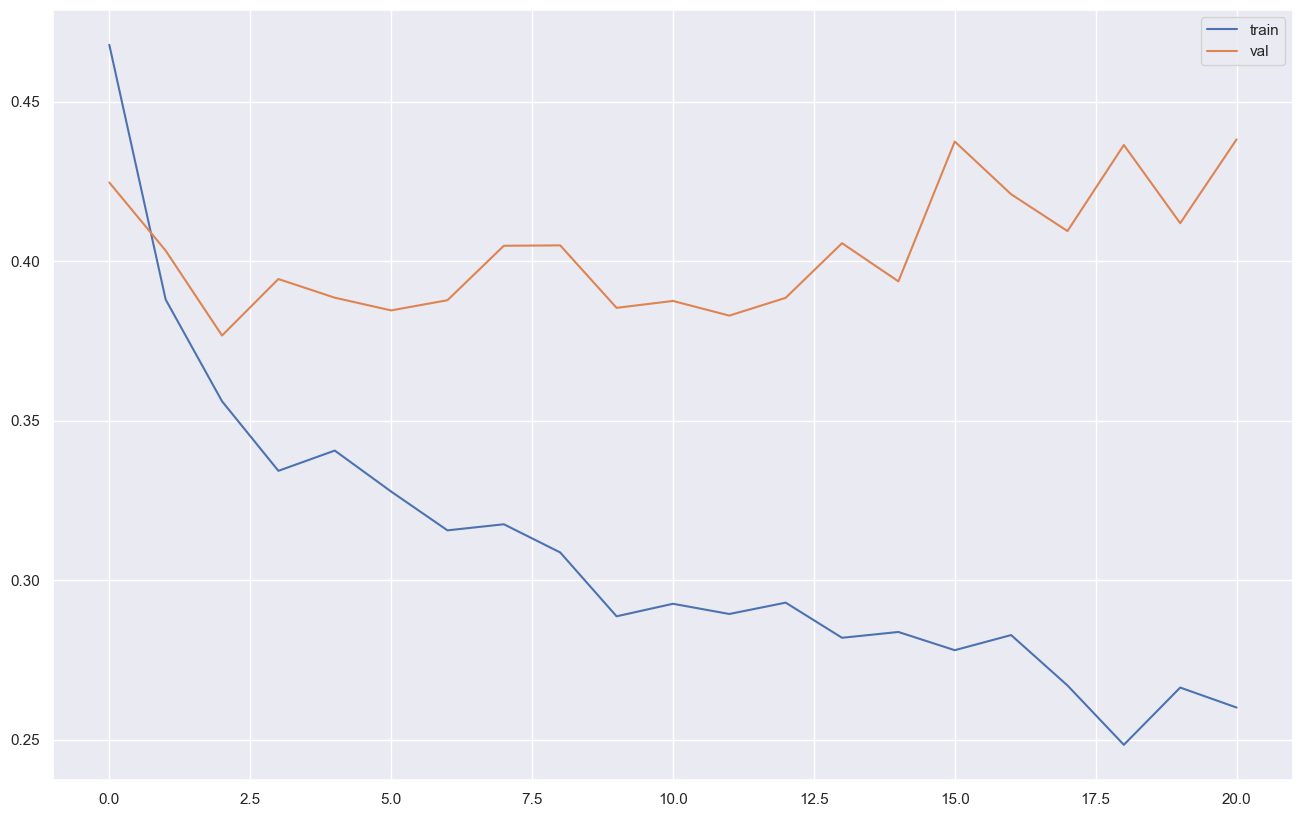

In [77]:

plt.plot(result.history['loss'], label='train')
plt.plot(result.history['val_loss'], label='val')
plt.legend()

In [ ]:
model_LSTM.histroy

In [291]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
!pip install tensorflow-gpu

In [92]:
performance_measures = model_training_and_validation(model_DNN, "DNN", splits)

116/116 [==============================] - 4s 6ms/step - loss: 0.5054 - auc: 0.5543 - binary_accuracy: 0.7999


AttributeError: 'Functional' object has no attribute 'predict_proba'

In [ ]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [74]:
from rdkit.Chem import AllChem, Descriptors
# Define function to convert SMILES to descriptors
def smiles_to_desc(smiles):
    mol = Chem.MolFromSmiles(smiles)
    desc = [Descriptors.MolWt(mol), Descriptors.NumRotatableBonds(mol), Descriptors.TPSA(mol)] + list(AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048))
    return desc

In [75]:
test_s = df.iloc()[0]['smiles']

In [76]:
features_s = np.array(smiles_to_desc(test_s))

In [73]:
features_s.shape

(2051,)

In [78]:
len(set(df['smiles']))

4635

In [91]:
X_train.shape

AttributeError: 'list' object has no attribute 'shape'

In [123]:
!pip install imbalanced-learn

   ---------------------------------------- 0.0/235.6 kB ? eta -:--:--
   ---------------------------------------  235.5/235.6 kB 7.3 MB/s eta 0:00:01
   ---------------------------------------- 235.6/235.6 kB 4.8 MB/s eta 0:00:00
